# 2. Use of openAlex data

OpenAlex returns the following publication metadata:

- Authors
- Author position
- Author PIDs
- Author affiliations and institutional PIDs
- Title
- Year
- Abstract
- Concepts and their relatedness to the paper under consideration
- is open access
- …

-> these data can answer some relevant questions:

Where do the authors work? The more recent the publication the more likely the affiliation on the publication is the current place of work. More up-to-date information could be found on their ORCID profile.

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import geopandas as gpd
import pickle
import operator
from itertools import chain

## Functions

In [22]:
# get authorship information from raw dataframe

def get_authorship(df_input):
    # create empty dataframe with all authorship attributes
    authorkeys = df_input["authorships"][0][0].keys()
    df = pd.DataFrame(columns= list(authorkeys).append(["publication_id","publication_date",
                                                        "openalex_id","orcid","display_name"]))
    
    # get authorship information from each publication
    for _, result in df_input.iterrows():
        new_df = pd.DataFrame.from_dict(result["authorships"]) # multiple authors per publication
        
        # add publication date and id
        new_df["publication_date"] = result["publication_date"]
        new_df["publication_id"] = result["id"]
        
        # disassemble author info
        new_df = new_df.assign(openalex_id=None, orcid=None, display_name=None)
        
        for i, author in new_df.iterrows():
            new_df.at[i, "openalex_id"] = author["author"]["id"]
            new_df.at[i, "orcid"] = author["author"]["orcid"]
            new_df.at[i, "display_name"] = author["author"]["display_name"]
        
        df = pd.concat([df, new_df]) # add to total dataframe
    
    # change index from author position on publication to real index
    df.reset_index(inplace=True)
    df = df.rename(columns={"index":"absolute_position"})
    
    return df

In [23]:
def single_authors(df_input):
    # keep most recent publication per author
    keep_df = pd.DataFrame(columns=df_input.keys())
    
    for author in set(df_input["openalex_id"]): # go over each unique author
        # get all rows that match author
        publications = df_input[df_input["openalex_id"]==author]
        # get most recent one
        most_recent = publications["publication_date"].max()
        keep_df = pd.concat([keep_df, publications[publications["publication_date"]==most_recent]])
    
    return keep_df

In [211]:
def freq_country_codes(df):
    # get list of country codes of institutions
    countries = []
    
    for institute in chain.from_iterable(df["institutions"]):
        if institute:
            if institute["country_code"]:
                countries.append(institute["country_code"])
        
    # count every country's frequency in the list
    countries_freq = {}
    
    for country in countries:
        if country in countries_freq:
            countries_freq[country] += 1
        else:
            countries_freq[country] = 1
    
    return countries_freq

In [192]:
list(chain.from_iterable(singles_eujot["institutions"]))[0]

{'id': 'https://openalex.org/I153976015',
 'display_name': 'University of Ljubljana',
 'ror': 'https://ror.org/05njb9z20',
 'country_code': 'SI',
 'type': 'education'}

In [204]:
list(chain.from_iterable(single_authors_journal["institutions"]))[1]

{'id': 'https://openalex.org/I2801511303',
 'display_name': 'Museums Victoria',
 'ror': 'https://ror.org/04mf3mq37',
 'country_code': 'AU',
 'type': 'archive'}

In [147]:
# get worldmap
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# convert 3-letter codes to 2-letter codes used for frequencies
country_codes = pd.read_csv("countries_codes_and_coordinates.csv")
country_codes = country_codes.applymap(lambda x: x.replace(' "', ""))
country_codes = country_codes.applymap(lambda x: x.replace('"', ""))

worldmap = worldmap.rename(columns={"iso_a3":"Alpha-3 code"})
worldmap = pd.merge(worldmap, country_codes[["Alpha-2 code", "Alpha-3 code"]], 
                    on="Alpha-3 code", how="left")

In [148]:
# get freqs into worldmap df
def freqs_to_worldmap(freqs, worldmap):
    worldmap["freq"] = worldmap["Alpha-2 code"].map(freqs)
    worldmap["freq"].fillna(0, inplace=True)
    return worldmap

In [149]:
def europe_institutions_map(worldmap_with_freqs):
    fig, europe = plt.subplots(1, 1)
    minx, miny, maxx, maxy = [-25, 30, 45, 80]
    europe.set_xlim(minx, maxx)
    europe.set_ylim(miny, maxy)

    europemap = worldmap_with_freqs.loc[worldmap["continent"] == "Europe"]
    europemap.plot(column='freq', ax=europe, legend=True)

## Results
### 2.1. Mapping institutions

In [163]:
# load previous data
eujot_df = pd.read_pickle("./data/europeanjournaloftaxonomy.pkl")

In [164]:
authors_eujot = get_authorship(eujot_df)
authors_eujot

,absolute_position,author_position,author,institutions,raw_affiliation_string,publication_date,publication_id,openalex_id,orcid,display_name
0,0,first,"{'id': 'https://openalex.org/A2594966570', 'di...","[{'id': 'https://openalex.org/I113171187', 'di...",Illinois Natural History Survey#R##N#Prairie R...,2013-05-29,https://openalex.org/W2012719615,https://openalex.org/A2594966570,https://orcid.org/0000-0002-3341-3560,James N. Zahniser
1,1,last,"{'id': 'https://openalex.org/A2106323028', 'di...","[{'id': 'https://openalex.org/I113171187', 'di...",Illinois Natural History Survey#R##N#Prairie R...,2013-05-29,https://openalex.org/W2012719615,https://openalex.org/A2106323028,https://orcid.org/0000-0003-4005-4305,Christopher H. Dietrich
2,0,first,"{'id': 'https://openalex.org/A2223792697', 'di...","[{'id': 'https://openalex.org/I4210162824', 'd...",Centre de Théorisation et de Modélisation de l...,2017-02-21,https://openalex.org/W2590646912,https://openalex.org/A2223792697,https://orcid.org/0000-0002-1335-8015,Hervé Philippe
3,1,middle,"{'id': 'https://openalex.org/A2144877009', 'di...","[{'id': 'https://openalex.org/I4210135640', 'd...",Laboratoire de Biométrie et Biologie Evolutive...,2017-02-21,https://openalex.org/W2590646912,https://openalex.org/A2144877009,https://orcid.org/0000-0001-9532-5251,Damien M. de Vienne
4,2,middle,"{'id': 'https://openalex.org/A2294877165', 'di...","[{'id': 'https://openalex.org/I24906876', 'dis...","SupAgro, UMR AGAP, 34398 Montpellier",2017-02-21,https://openalex.org/W2590646912,https://openalex.org/A2294877165,https://orcid.org/0000-0002-9308-7541,Vincent Ranwez
...,...,...,...,...,...,...,...,...,...,...
3559,3,middle,"{'id': 'https://openalex.org/A4313112019', 'di...","[{'id': 'https://openalex.org/I88830068', 'dis...","College of Life Sciences, Shaanxi Normal Unive...",2022-12-21,https://openalex.org/W4312090916,https://openalex.org/A4313112019,None,"Li, Gang"
3560,4,middle,"{'id': 'https://openalex.org/A4313112020', 'di...","[{'id': 'https://openalex.org/I187175081', 'di...","School of Biological Sciences & Engineering, S...",2022-12-21,https://openalex.org/W4312090916,https://openalex.org/A4313112020,None,"Liu, Xin"
3561,5,middle,"{'id': 'https://openalex.org/A4313112021', 'di...","[{'id': 'https://openalex.org/I4210100670', 'd...","Sichuan Wanglang National Nature Reserve, Ping...",2022-12-21,https://openalex.org/W4312090916,https://openalex.org/A4313112021,None,"Zhao, Lian-Jun"
3562,6,last,"{'id': 'https://openalex.org/A4313112022', 'di...","[{'id': 'https://openalex.org/I20616075', 'dis...",Key Laboratory of Biodiversity Formation Mecha...,2022-12-21,https://openalex.org/W4312090916,https://openalex.org/A4313112022,None,"Chen, Zhen-Ning"


In [197]:
singles_eujot = single_authors(authors_eujot)

In [187]:
singles_eujot["institutions"][0]["country_code"]

TypeError: list indices must be integers or slices, not str

In [212]:
eujot_countries_freq = freq_country_codes(singles_eujot)
eujot_countries_freq

{'SI': 12,
 'BR': 243,
 'US': 144,
 'RU': 83,
 'CN': 192,
 'IT': 80,
 'CL': 8,
 'GB': 71,
 'DE': 110,
 'IR': 28,
 'DK': 29,
 'EC': 4,
 'IN': 62,
 'LT': 7,
 'TZ': 3,
 'FR': 131,
 'BE': 96,
 'ES': 80,
 'JP': 32,
 'RS': 23,
 'PL': 32,
 'SA': 13,
 'CZ': 41,
 'VN': 36,
 'MX': 51,
 'TH': 34,
 'LK': 6,
 'SK': 14,
 'DZ': 2,
 'PK': 11,
 'NL': 21,
 'HR': 7,
 'CA': 16,
 'NO': 9,
 'AR': 19,
 'KE': 3,
 'TR': 16,
 'MY': 9,
 'CO': 15,
 'MT': 2,
 'AU': 34,
 'LU': 5,
 'KW': 1,
 'SE': 30,
 'TW': 17,
 'ZA': 24,
 'BG': 9,
 'NP': 1,
 'AT': 17,
 'PE': 10,
 'RE': 7,
 'NZ': 18,
 'LA': 3,
 'BW': 1,
 'MG': 6,
 'CH': 14,
 'FI': 16,
 'KH': 5,
 'PT': 19,
 'HU': 12,
 'HN': 1,
 'CU': 2,
 'CM': 4,
 'RO': 7,
 'GT': 1,
 'BJ': 2,
 'KZ': 2,
 'SG': 7,
 'GR': 10,
 'GE': 2,
 'PH': 5,
 'GA': 1,
 'CD': 3,
 'BO': 1,
 'TN': 4,
 'ID': 7,
 'IL': 6,
 'KR': 13,
 'BS': 1,
 'BD': 2,
 'VE': 2,
 'IE': 1,
 'CR': 4,
 'BF': 1,
 'NG': 2,
 'GP': 3,
 'BN': 1,
 'EG': 2,
 'SN': 2,
 'ET': 1,
 'PF': 1,
 'KG': 1,
 'UY': 2,
 'UA': 1,
 'CY': 1,
 'A

In [195]:
singles_eujot

,absolute_position,author_position,author,institutions,raw_affiliation_string,publication_date,publication_id,openalex_id,orcid,display_name
524,1,middle,"{'id': 'https://openalex.org/A1712136002', 'di...","[{'id': 'https://openalex.org/I153976015', 'di...","Department of Biology, Biotechnical Faculty, U...",2015-12-16,https://openalex.org/W2221789937,https://openalex.org/A1712136002,https://orcid.org/0000-0003-1982-8724,Cene Fišer
2025,1,middle,"{'id': 'https://openalex.org/A4223351641', 'di...","[{'id': None, 'display_name': 'Av. Municipal, ...","Av. Municipal, 45, Siderópolis, CEP 88860-000,...",2022-02-21,https://openalex.org/W4220742344,https://openalex.org/A4223351641,None,"Feltrin, Caio R.M."
1882,0,first,"{'id': 'https://openalex.org/A2284910746', 'di...","[{'id': 'https://openalex.org/I61722147', 'dis...",Laboratório de Diversidade e Sistemática de Ar...,2021-05-11,https://openalex.org/W3162920938,https://openalex.org/A2284910746,https://orcid.org/0000-0003-4448-3940,Patrícia E. S. Rodrigues
2170,0,first,"{'id': 'https://openalex.org/A2141167096', 'di...","[{'id': 'https://openalex.org/I1338124936', 'd...","Natural History Museum of Neuchâtel, Terreaux ...",2016-02-10,https://openalex.org/W2261226384,https://openalex.org/A2141167096,https://orcid.org/0000-0003-2481-5709,Jessica R. Litman
1961,3,last,"{'id': 'https://openalex.org/A2005369304', 'di...","[{'id': 'https://openalex.org/I4210136202', 'd...",A.V. Zhirmunsky National Scientific Center of ...,2021-09-30,https://openalex.org/W3204028974,https://openalex.org/A2005369304,https://orcid.org/0000-0002-0673-1109,Tatiana V. Neretina
...,...,...,...,...,...,...,...,...,...,...
2537,0,first,"{'id': 'https://openalex.org/A3178414181', 'di...","[{'id': None, 'display_name': 'Biodiversity In...",Biodiversity Inventory for Conservation (BINCO...,2020-04-28,https://openalex.org/W3022462728,https://openalex.org/A3178414181,https://orcid.org/0000-0002-0461-3715,Brogan L. Pett
37,5,middle,"{'id': 'https://openalex.org/A1994917088', 'di...","[{'id': 'https://openalex.org/I183263030', 'di...","Department of Biodiversity, Institute of Scien...",2019-09-16,https://openalex.org/W2974208280,https://openalex.org/A1994917088,https://orcid.org/0000-0002-6051-5845,Mohsen Mehrparvar
2257,3,middle,"{'id': 'https://openalex.org/A2207559881', 'di...","[{'id': 'https://openalex.org/I110017253', 'di...","IRBI, Institut de Recherche sur la Biologie de...",2017-03-14,https://openalex.org/W2603090724,https://openalex.org/A2207559881,https://orcid.org/0000-0001-5829-0096,Alain Lenoir
3433,1,middle,"{'id': 'https://openalex.org/A4297052310', 'di...",[],,2022-09-15,https://openalex.org/W4297051836,https://openalex.org/A4297052310,https://orcid.org/0000-0001-5801-4681,Philip Alderslade


In [169]:
worldmap = freqs_to_worldmap(eujot_countries_freq, worldmap)
worldmap

,pop_est,continent,name,Alpha-3 code,gdp_md_est,geometry,Alpha-2 code,freq
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ,0.0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ,3.0
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",EH,0.0
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA,16.0
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US,144.0
...,...,...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",RS,23.0
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",ME,1.0
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,0.0
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TT,0.0


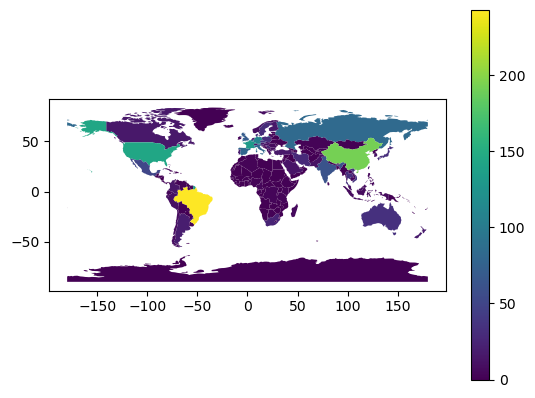

In [170]:
fig, ax = plt.subplots(1,1)
# (mercator projection)
# worldmap_merc = worldmap.to_crs("EPSG:3395") 
worldmap.plot(column='freq', ax=ax, legend=True)
plt.savefig("./figures/institutions_map_eujof.png")

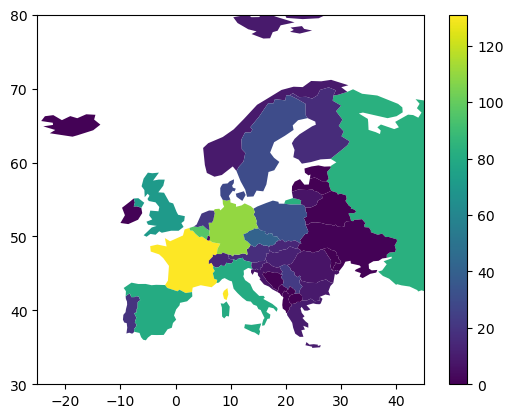

In [171]:
# french journal, french results
europe_institutions_map(worldmap)
plt.savefig("./figures/europe_institutions_map_eujof.png")

In [213]:
countries_freq = freq_country_codes(single_authors_journal)
countries_freq

{'AU': 1506,
 'IN': 2204,
 'GT': 30,
 'GB': 1582,
 'US': 8681,
 'BR': 5079,
 'CL': 315,
 'TR': 589,
 'SG': 161,
 'MY': 354,
 'ZA': 616,
 'JP': 1302,
 'CN': 9832,
 'TN': 57,
 'VE': 75,
 'RU': 1342,
 'MX': 1428,
 'PA': 83,
 'IR': 693,
 'ES': 1343,
 'TZ': 20,
 'DE': 1755,
 'CH': 395,
 'VN': 421,
 'EG': 87,
 'NZ': 367,
 'BE': 553,
 'FR': 1113,
 'TH': 708,
 'IL': 131,
 'CZ': 613,
 'HU': 244,
 'CO': 709,
 'PG': 14,
 'NO': 219,
 'LA': 35,
 'CA': 1019,
 'PL': 727,
 'FI': 194,
 'IT': 985,
 'SE': 351,
 'CR': 116,
 'MG': 66,
 'CY': 23,
 'TW': 513,
 'AR': 886,
 'AL': 15,
 'BG': 90,
 'PT': 344,
 'PE': 197,
 'UA': 92,
 'IS': 29,
 'NP': 22,
 'KH': 14,
 'DK': 204,
 'SA': 107,
 'ID': 209,
 'RO': 66,
 'SK': 178,
 'NL': 341,
 'KR': 600,
 'EC': 167,
 'EE': 34,
 'LT': 62,
 'PK': 186,
 'MA': 52,
 'PH': 184,
 'GQ': 1,
 'RW': 6,
 'HR': 104,
 'CU': 44,
 'RS': 157,
 'SI': 79,
 'BO': 36,
 'UY': 59,
 'GA': 10,
 'IQ': 22,
 'AT': 332,
 'RE': 33,
 'GR': 188,
 'UZ': 37,
 'BF': 12,
 'BJ': 23,
 'BY': 17,
 'KW': 6,
 'MK

In [216]:
worldmap = freqs_to_worldmap(countries_freq, worldmap)
worldmap

,pop_est,continent,name,Alpha-3 code,gdp_md_est,geometry,Alpha-2 code,freq
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ,5.0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ,20.0
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",EH,0.0
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA,1019.0
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US,8681.0
...,...,...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",RS,157.0
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",ME,9.0
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,0.0
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TT,8.0


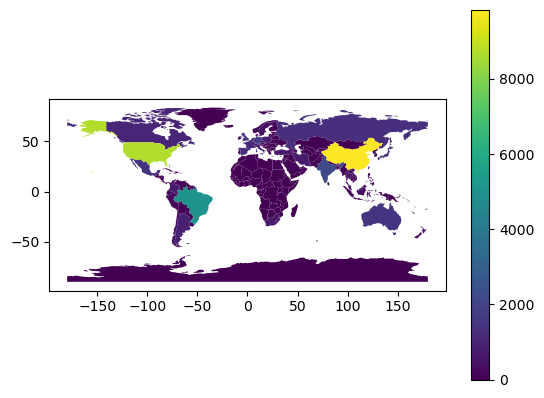

In [217]:
fig, ax = plt.subplots(1,1)
# (mercator projection)
# worldmap_merc = worldmap.to_crs("EPSG:3395") 
worldmap.plot(column='freq', ax=ax, legend=True)
plt.savefig("./figures/institutions_map_all_journals.png")

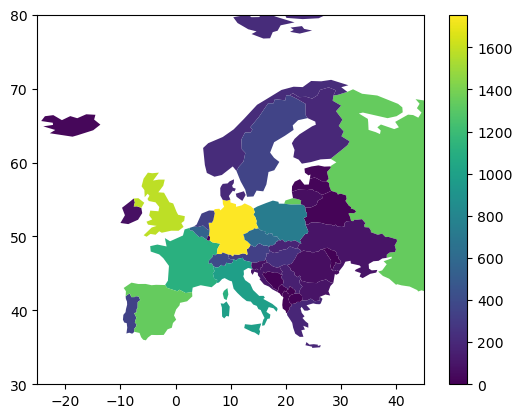

In [218]:
# french journal, french results
europe_institutions_map(worldmap)
plt.savefig("./figures/europe_institutions_map_all_journals.png")

### 2.2. Nightingale rose charts of orcid profiles per journal

In [3]:
journals = pd.read_pickle("./data/tax_nomen_phyl_journals.pkl")
journals

,index,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,...,alternate_host_venues,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated
0,0,https://openalex.org/W2794518289,https://doi.org/10.21805/bzn.v73i2.a2,Declaration 45 — Addition of Recommendations t...,Declaration 45 — Addition of Recommendations t...,2017,2017-03-01,{'openalex': 'https://openalex.org/W2794518289...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V2764437286', 'd...",[],"[https://openalex.org/W10855044, https://opena...",https://api.openalex.org/works/W2794518289/ngrams,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 2}, {'year':...",2022-12-31T11:22:00.095298,2018-04-06,NaN
1,1,https://openalex.org/W2146786538,https://doi.org/10.21805/bzn.v72i1.a14,A mixed bag: when are early online publication...,A mixed bag: when are early online publication...,2015,2015-03-01,{'openalex': 'https://openalex.org/W2146786538...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V2764437286', 'd...","[https://openalex.org/W280275763, https://open...","[https://openalex.org/W102778231, https://open...",https://api.openalex.org/works/W2146786538/ngrams,"{'The': [0, 77, 115, 190], '2012': [1], 'Amend...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 2}, {'year':...",2023-01-05T20:30:18.093880,2016-06-24,NaN
2,2,https://openalex.org/W2568389130,https://doi.org/10.21805/bzn.v73i1.a2,Describing new species in the absence of sampl...,Describing new species in the absence of sampl...,2016,2016-03-01,{'openalex': 'https://openalex.org/W2568389130...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V2764437286', 'd...","[https://openalex.org/W1896782350, https://ope...","[https://openalex.org/W564072285, https://open...",https://api.openalex.org/works/W2568389130/ngrams,"{'Abstract.': [0], 'Photographs': [1], 'of': [...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 1}, {'year':...",2023-01-07T11:12:52.600727,2017-01-13,NaN
3,3,https://openalex.org/W2200831548,https://doi.org/10.21805/bzn.v72i3.a2,Electronic publications need registration in Z...,Electronic publications need registration in Z...,2015,2015-09-30,{'openalex': 'https://openalex.org/W2200831548...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V2764437286', 'd...","[https://openalex.org/W1509756958, https://ope...","[https://openalex.org/W2111054652, https://ope...",https://api.openalex.org/works/W2200831548/ngrams,"{'The': [0], '2012': [1], 'Amendment': [2], 't...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 2}, {'year':...",2023-01-06T13:23:59.566794,2016-06-24,NaN
4,4,https://openalex.org/W2396849678,https://doi.org/10.21805/bzn.v73i1.a22,"Case 3700DiplodocusMarsh, 1878 (Dinosauria, Sa...","Case 3700DiplodocusMarsh, 1878 (Dinosauria, Sa...",2016,2016-03-01,{'openalex': 'https://openalex.org/W2396849678...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[{'id': 'https://openalex.org/V2764437286', 'd...","[https://openalex.org/W1490929606, https://ope...","[https://openalex.org/W1981745406, https://ope...",https://api.openalex.org/works/W2396849678/ngrams,"{'Abstract.': [0], 'The': [1, 59, 121], 'purpo...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2019, 'cited_by_count': 1}, {'year':...",2023-01-05T20:17:51.949923,2016-06-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56116,224,https://openalex.org/W4297831205,https://doi.org/10.3989/graellsia.2022.v78.344,Chalcidoid parasitoids (Hymenoptera: Chalcidoi...,Chalcidoid parasitoids (Hymen

In [8]:
journals[["publication_year", "host_venue"]]

,publication_year,host_venue
0,2017,"{'id': 'https://openalex.org/V2764437286', 'is..."
1,2015,"{'id': 'https://openalex.org/V2764437286', 'is..."
2,2016,"{'id': 'https://openalex.org/V2764437286', 'is..."
3,2015,"{'id': 'https://openalex.org/V2764437286', 'is..."
4,2016,"{'id': 'https://openalex.org/V2764437286', 'is..."
...,...,...
56116,2022,"{'id': 'https://openalex.org/V62977146', 'issn..."
56117,2022,"{'id': 'https://openalex.org/V62977146', 'issn..."
56118,2022,"{'id': 'https://openalex.org/V62977146', 'issn..."
56119,2014,"{'id': 'https://openalex.org/V62977146', 'issn..."


In [15]:
journals["host_venue"][0]

{'id': 'https://openalex.org/V2764437286',
 'issn_l': '0007-5167',
 'issn': ['2057-0570', '0007-5167'],
 'display_name': 'The Bulletin of zoological nomenclature',
 'publisher': 'International Trust for Zoological Nomenclature',
 'type': 'journal',
 'url': 'https://bioone.org/journals/The-Bulletin-of-Zoological-Nomenclature/volume-73/issue-2-4/bzn.v73i2.a2/Declaration-45--Addition-of-Recommendations-to-Article-73-and/10.21805/bzn.v73i2.a2.pdf',
 'is_oa': True,
 'version': 'publishedVersion',
 'license': None}

In [19]:
for i, article in journals.iterrows():
    journals.loc[i, "issn-l"] = article["host_venue"]["issn_l"]
    journals.loc[i, "journal_name"] = article["host_venue"]["display_name"]

journals

,index,id,doi,title,display_name,publication_year,publication_date,ids,host_venue,type,...,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,is_authors_truncated,issn-l,journal_name
0,0,https://openalex.org/W2794518289,https://doi.org/10.21805/bzn.v73i2.a2,Declaration 45 — Addition of Recommendations t...,Declaration 45 — Addition of Recommendations t...,2017,2017-03-01,{'openalex': 'https://openalex.org/W2794518289...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[https://openalex.org/W10855044, https://opena...",https://api.openalex.org/works/W2794518289/ngrams,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2022, 'cited_by_count': 2}, {'year':...",2022-12-31T11:22:00.095298,2018-04-06,NaN,0007-5167,The Bulletin of zoological nomenclature
1,1,https://openalex.org/W2146786538,https://doi.org/10.21805/bzn.v72i1.a14,A mixed bag: when are early online publication...,A mixed bag: when are early online publication...,2015,2015-03-01,{'openalex': 'https://openalex.org/W2146786538...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[https://openalex.org/W102778231, https://open...",https://api.openalex.org/works/W2146786538/ngrams,"{'The': [0, 77, 115, 190], '2012': [1], 'Amend...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 2}, {'year':...",2023-01-05T20:30:18.093880,2016-06-24,NaN,0007-5167,The Bulletin of zoological nomenclature
2,2,https://openalex.org/W2568389130,https://doi.org/10.21805/bzn.v73i1.a2,Describing new species in the absence of sampl...,Describing new species in the absence of sampl...,2016,2016-03-01,{'openalex': 'https://openalex.org/W2568389130...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[https://openalex.org/W564072285, https://open...",https://api.openalex.org/works/W2568389130/ngrams,"{'Abstract.': [0], 'Photographs': [1], 'of': [...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 1}, {'year':...",2023-01-07T11:12:52.600727,2017-01-13,NaN,0007-5167,The Bulletin of zoological nomenclature
3,3,https://openalex.org/W2200831548,https://doi.org/10.21805/bzn.v72i3.a2,Electronic publications need registration in Z...,Electronic publications need registration in Z...,2015,2015-09-30,{'openalex': 'https://openalex.org/W2200831548...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[https://openalex.org/W2111054652, https://ope...",https://api.openalex.org/works/W2200831548/ngrams,"{'The': [0], '2012': [1], 'Amendment': [2], 't...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2021, 'cited_by_count': 2}, {'year':...",2023-01-06T13:23:59.566794,2016-06-24,NaN,0007-5167,The Bulletin of zoological nomenclature
4,4,https://openalex.org/W2396849678,https://doi.org/10.21805/bzn.v73i1.a22,"Case 3700DiplodocusMarsh, 1878 (Dinosauria, Sa...","Case 3700DiplodocusMarsh, 1878 (Dinosauria, Sa...",2016,2016-03-01,{'openalex': 'https://openalex.org/W2396849678...,"{'id': 'https://openalex.org/V2764437286', 'is...",journal-article,...,"[https://openalex.org/W1981745406, https://ope...",https://api.openalex.org/works/W2396849678/ngrams,"{'Abstract.': [0], 'The': [1, 59, 121], 'purpo...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2019, 'cited_by_count': 1}, {'year':...",2023-01-05T20:17:51.949923,2016-06-24,NaN,0007-5167,The Bulletin of zoological nomenclature
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56116,224,https://openalex.org/W4297831205,https://doi.org/10.3989/graellsia.2022.v78.344,Chalcidoid parasitoids (Hymenoptera: Chalcidoi...,Chalcidoid parasitoids (Hymenoptera: Chalcidoi...,2022,2022-09-07,{'openalex': 'https://openalex.org/W4297831205...,"{'id': 'https://openalex.org/V62977146', 'issn...",journal-article,...,"[https://openalex.org/W1993615352, https://ope...",https://api.openalex.org/work

In [20]:
set(journals["journal_name"])

{'Animal Systematics, Evolution and Diversity',
 'Australian Systematic Botany',
 'Bionomina',
 'European journal of taxonomy',
 'Graellsia',
 'Insect systematics and diversity',
 'Journal of Systematics and Evolution',
 'Kew Bulletin',
 'Megataxa',
 'Molecular Phylogenetics and Evolution',
 'Native Plants Journal',
 'NeoBiota',
 'Nuytsia',
 'PhytoKeys',
 'Phytotaxa',
 'Russian entomological journal',
 'Singmulbullyuhakoeji',
 'Systematic Biology',
 'Systematic Entomology',
 'The Auk',
 'The Bulletin of zoological nomenclature',
 'Willdenowia',
 'ZooKeys',
 'Zoologica Scripta',
 'Zoosystematics and Evolution',
 'Zootaxa'}

In [30]:
# orcid: true or false?
journal_authors = get_authorship(journals)
journal_authors

,absolute_position,author_position,author,institutions,raw_affiliation_string,publication_date,publication_id,openalex_id,orcid,display_name
0,0,first,"{'id': 'https://openalex.org/A2750580969', 'di...",[],,2017-03-01,https://openalex.org/W2794518289,https://openalex.org/A2750580969,None,Iczn Iczn
1,0,first,"{'id': 'https://openalex.org/A2251180397', 'di...","[{'id': None, 'display_name': 'ICZN Commission...",ICZN Commissioner,2015-03-01,https://openalex.org/W2146786538,https://openalex.org/A2251180397,https://orcid.org/0000-0001-6065-0812,Frank-Thorsten Krell
2,0,first,"{'id': 'https://openalex.org/A2659846377', 'di...","[{'id': None, 'display_name': '(e-mail: ) Ivan...",(e-mail: ) Ivan.Lobl@bluewin.ch,2016-03-01,https://openalex.org/W2568389130,https://openalex.org/A2659846377,None,Ivan Löbl
3,1,middle,"{'id': 'https://openalex.org/A248203991', 'dis...","[{'id': None, 'display_name': '(e-mail: ) Alic...",(e-mail: ) Alice.Cibois@ville-ge.ch,2016-03-01,https://openalex.org/W2568389130,https://openalex.org/A248203991,https://orcid.org/0000-0002-3668-071X,Alice Cibois
4,2,last,"{'id': 'https://openalex.org/A2572651080', 'di...","[{'id': None, 'display_name': '(e-mail: ) Bern...",(e-mail: ) Bernard.Landry@ville-ge.ch,2016-03-01,https://openalex.org/W2568389130,https://openalex.org/A2572651080,https://orcid.org/0000-0002-6005-1067,Bernard Landry
...,...,...,...,...,...,...,...,...,...,...
174328,1,middle,"{'id': 'https://openalex.org/A2564724685', 'di...",[],,2014-12-19,https://openalex.org/W966503361,https://openalex.org/A2564724685,None,Ana I. Camacho Pérez
174329,2,middle,"{'id': 'https://openalex.org/A2561458998', 'di...",[],,2014-12-19,https://openalex.org/W966503361,https://openalex.org/A2561458998,None,M. Ángeles Ramos
174330,3,middle,"{'id': 'https://openalex.org/A2297594041', 'di...",[],,2014-12-19,https://openalex.org/W966503361,https://openalex.org/A2297594041,https://orcid.org/0000-0002-4711-7455,José Luis Nieves-Aldrey
174331,4,last,"{'id': 'https://openalex.org/A2329367063', 'di...",[],,2014-12-19,https://openalex.org/W966503361,https://openalex.org/A2329367063,https://orcid.org/0000-0001-5894-9866,José F. Fernández


In [154]:
single_authors_journal = single_authors(journal_authors)
single_authors_journal.reset_index()

KeyboardInterrupt: 

In [156]:
single_authors_journal = single_authors_journal.reset_index()
single_authors_journal

,index,absolute_position,author_position,author,institutions,raw_affiliation_string,publication_date,publication_id,openalex_id,orcid,display_name
0,47883,1,last,"{'id': 'https://openalex.org/A3207127450', 'di...","[{'id': None, 'display_name': 'Institute for B...",Institute for Biological Problems of Cryolitho...,2014-03-06,https://openalex.org/W2162987225,https://openalex.org/A3207127450,None,Zhaohui Luo
1,136215,0,first,"{'id': 'https://openalex.org/A2670900666', 'di...","[{'id': 'https://openalex.org/I2801511303', 'd...","Museums Victoria, PO Box 666, Melbourne VIC 30...",2022-02-01,https://openalex.org/W3212146458,https://openalex.org/A2670900666,None,Katja Boysen
2,49891,0,first,"{'id': 'https://openalex.org/A3049505097', 'di...","[{'id': 'https://openalex.org/I1338006420', 'd...","Zoological Survey of India, Prani Vigyan Bhawa...",2017-07-20,https://openalex.org/W2737504539,https://openalex.org/A3049505097,https://orcid.org/0000-0001-9067-3011,Sankarsan Roy
3,415,4,middle,"{'id': 'https://openalex.org/A4306209462', 'di...","[{'id': None, 'display_name': 'Tiroler Landesm...","Tiroler Landesmuseen Betriebsges.m.b.H., Samml...",2022-10-15,https://openalex.org/W4306167771,https://openalex.org/A4306209462,None,Peter Huemer
4,44022,0,first,"{'id': 'https://openalex.org/A2399179588', 'di...","[{'id': 'https://openalex.org/I156341307', 'di...",,2020-05-01,https://openalex.org/W3023757048,https://openalex.org/A2399179588,None,Manuel A. Barrios-Izás
...,...,...,...,...,...,...,...,...,...,...,...
76599,152320,2,last,"{'id': 'https://openalex.org/A1954442483', 'di...","[{'id': 'https://openalex.org/I1281735042', 'd...",,2021-01-01,https://openalex.org/W3166775917,https://openalex.org/A1954442483,None,Jan Klimaszewski
76600,3568,8,middle,"{'id': 'https://openalex.org/A4227558289', 'di...","[{'id': 'https://openalex.org/I138816502', 'di...","Office de l'Environnement de la Corse, Corte, ...",2021-12-01,https://openalex.org/W4225552263,https://openalex.org/A4227558289,None,"Petit, Yohan"
76601,146759,2,middle,"{'id': 'https://openalex.org/A4207544800', 'di...",[],,2022-01-24,https://openalex.org/W4206979111,https://openalex.org/A4207544800,None,Li-Shen Qian
76602,8691,0,first,"{'id': 'https://openalex.org/A2016320768', 'di...","[{'id': 'https://openalex.org/I2799614521', 'd...","Identification and Naming Department, Royal Bo...",2018-10-01,https://openalex.org/W2895675554,https://openalex.org/A2016320768,None,Kaj Vollesen


In [140]:
len(single_authors_journal.index)

76604

In [139]:
len(single_authors_journal.index) - single_authors_journal["orcid"].count(None)

49192

In [116]:
# get single authorship PER JOURNAL
journal_names = sorted(list(set(journals["journal_name"])))
data_plot = pd.DataFrame(columns = journal_names, index = ["authors", "orcids"])

for j in journal_names:
    df = journals[journals["journal_name"]==j]
    authors_df = get_authorship(df.reset_index())
    single_df = single_authors(authors_df)
    
    data_plot.at["authors", j] = len(single_df.index)
    data_plot.at["orcids", j] = len(single_df.index) - single_df["orcid"].count(None) 
    # watch out, "count(None)" actually counts how many values are NOT None
    print(j)

data_plot

['Animal Systematics, Evolution and Diversity', 'Australian Systematic Botany', 'Bionomina', 'European journal of taxonomy', 'Graellsia', 'Insect systematics and diversity', 'Journal of Systematics and Evolution', 'Kew Bulletin', 'Megataxa', 'Molecular Phylogenetics and Evolution', 'Native Plants Journal', 'NeoBiota', 'Nuytsia', 'PhytoKeys', 'Phytotaxa', 'Russian entomological journal', 'Singmulbullyuhakoeji', 'Systematic Biology', 'Systematic Entomology', 'The Auk', 'The Bulletin of zoological nomenclature', 'Willdenowia', 'ZooKeys', 'Zoologica Scripta', 'Zoosystematics and Evolution', 'Zootaxa']
Animal Systematics, Evolution and Diversity
Australian Systematic Botany
Bionomina
European journal of taxonomy
Graellsia
Insect systematics and diversity
Journal of Systematics and Evolution
Kew Bulletin
Megataxa
Molecular Phylogenetics and Evolution
Native Plants Journal
NeoBiota
Nuytsia
PhytoKeys
Phytotaxa
Russian entomological journal
Singmulbullyuhakoeji
Systematic Biology
Systematic Ent

,"Animal Systematics, Evolution and Diversity",Australian Systematic Botany,Bionomina,European journal of taxonomy,Graellsia,Insect systematics and diversity,Journal of Systematics and Evolution,Kew Bulletin,Megataxa,Molecular Phylogenetics and Evolution,...,Singmulbullyuhakoeji,Systematic Biology,Systematic Entomology,The Auk,The Bulletin of zoological nomenclature,Willdenowia,ZooKeys,Zoologica Scripta,Zoosystematics and Evolution,Zootaxa
authors,440,595,145,2755,380,560,3104,1183,82,11114,...,793,2844,1981,2473,789,709,11193,2269,676,28528
orcids,318,262,48,1307,124,215,1814,631,28,5328,...,590,1032,870,1251,537,365,6932,859,358,18686


In [137]:
sum(data_plot.loc["authors"])

94302

In [138]:
sum(data_plot.loc["orcids"])

53619

In [ ]:
# idee: instance of scientific journal, publisher is instance of botanical garden

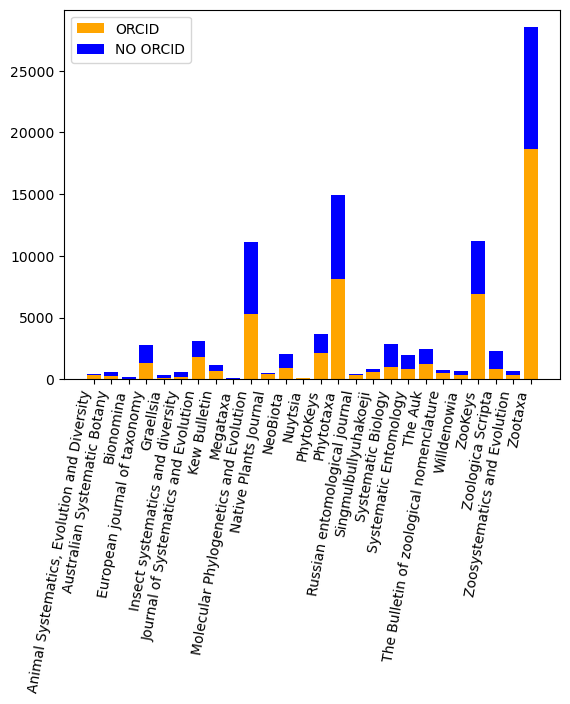

<Figure size 640x480 with 0 Axes>

In [144]:
labels = data_plot.keys()
no_orcid = list(map(operator.sub, list(data_plot.loc["authors",]), list(data_plot.loc["orcids",])))

fig, ax = plt.subplots()

ax.bar(labels, data_plot.loc["orcids",],
       label="ORCID", color="orange")
ax.bar(labels, no_orcid, bottom=data_plot.loc["orcids",],
       label="NO ORCID", color="blue")
ax.legend()

plt.xticks(rotation=80, ha="right")
plt.show()

plt.savefig("./figures/absolute_orcid_authors_journals.png")

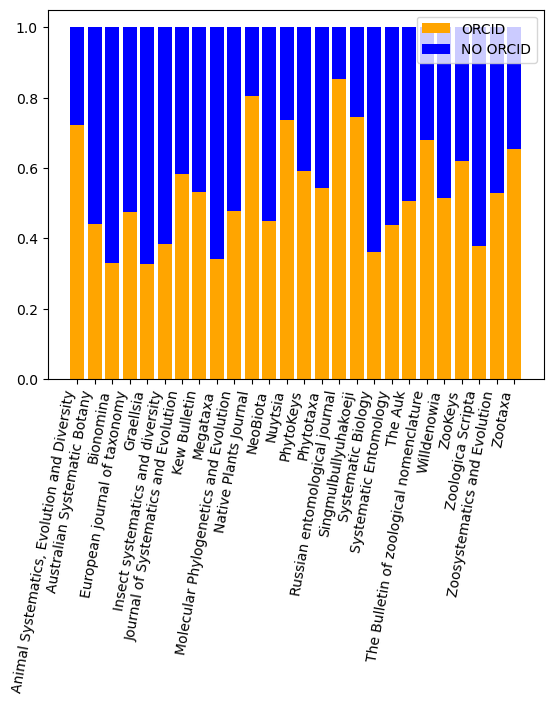

<Figure size 640x480 with 0 Axes>

In [143]:
perc_orcids = np.divide(data_plot.loc["orcids",], data_plot.loc["authors",])
perc_no_orcids = 1 - perc_orcids

fig, ax = plt.subplots()

ax.bar(labels, perc_orcids,
       label="ORCID", color="orange")
ax.bar(labels, perc_no_orcids, bottom=perc_orcids,
       label="NO ORCID", color="blue")
ax.legend()

plt.xticks(rotation=80, ha="right")
plt.show()

plt.savefig("./figures/relative_orcid_authors_journals.png")

In [122]:
perc_orcids

Animal Systematics, Evolution and Diversity    0.722727
Australian Systematic Botany                   0.440336
Bionomina                                      0.331034
European journal of taxonomy                    0.47441
Graellsia                                      0.326316
Insect systematics and diversity               0.383929
Journal of Systematics and Evolution           0.584407
Kew Bulletin                                    0.53339
Megataxa                                       0.341463
Molecular Phylogenetics and Evolution          0.479395
Native Plants Journal                          0.803738
NeoBiota                                       0.450192
Nuytsia                                        0.735632
PhytoKeys                                      0.590723
Phytotaxa                                      0.544368
Russian entomological journal                  0.853365
Singmulbullyuhakoeji                            0.74401
Systematic Biology                             0